In [1]:
pip install tensorflow

     |████████████████████████████████| 458.3 MB 17 kB/s s eta 0:00:01
     |████████████████████████████████| 5.6 MB 63.7 MB/s eta 0:00:01     |███████████████████████████▎    | 4.7 MB 63.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 4.3 MB 38.6 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 79.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 66.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 60.3 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 79.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 78.8 MB/s eta 0:00:01
     |██████████████████████████████

In [2]:
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tensorflow as tf

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'data-445'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key = 'Fall_2021/In_Class_Assignments/framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
heart = pd.read_csv(file_content_stream)
heart = heart.dropna()
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
## Defining the input and target variables
X = heart[['age', 'currentSmoker', 'totChol', 'BMI', 'heartRate']]
Y = heart['TenYearCHD']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [4]:
## Transforming the input variables
scaler_train = MinMaxScaler(feature_range = (0, 1)).fit(X_train)
X_train = scaler_train.transform(X_train)

scaler_test = MinMaxScaler(feature_range = (0, 1)).fit(X_test)
X_test = scaler_train.transform(X_test)

In [21]:
mlp1 = tf.keras.models.Sequential([
      tf.keras.layers.Dense(4, input_dim = 5, activation = 'tanh'),
      tf.keras.layers.Dense(2, activation = 'softmax')
])

mlp1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Building the model
mlp1.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), 
         epochs = 100,
         batch_size = 500, 
         validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)), 
         verbose = 0)

In [22]:
mlp2 = tf.keras.models.Sequential([
      tf.keras.layers.Dense(4, input_dim = 5, activation = 'relu'),
      tf.keras.layers.Dense(2, activation = 'softmax')
])

mlp2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Building the model
mlp2.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), 
         epochs = 100,
         batch_size = 500, 
         validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)),
         verbose = 0)

In [17]:
## Extracting predictions
mlp_pred1 = mlp1.predict(X_test)[:, 1]

## Changing likelihood to labels
mlp_pred1 = np.where(mlp_pred1 < 0.15, 0, 1)

## Computing the recall
recall_score(Y_test, mlp_pred1)

0.391304347826087

In [18]:
## Extracting predictions
mlp_pred2 = mlp2.predict(X_test)[:, 1]

## Changing likelihood to labels
mlp_pred2 = np.where(mlp_pred2 < 0.15, 0, 1)

## Computing the recall
recall_score(Y_test, mlp_pred2)

0.9739130434782609

# SVM

In [30]:
## Building the svm model
svm_md1 = SVC(kernel = 'rbf', probability = True).fit(X_train, Y_train)

## Predicting on the test dataset
svm_pred1 = svm_md1.predict_proba(X_test)[:, 1]

## Changing likelihood to labels
svm_pred1 = np.where(svm_pred1 < 0.15, 0, 1)

## Computing the recall
recall_score(Y_test, svm_pred1)

0.6521739130434783

In [31]:
## Building the svm model
svm_md2 = SVC(kernel = 'poly', probability = True).fit(X_train, Y_train)

## Predicting on the test dataset
svm_pred2 = svm_md2.predict_proba(X_test)[:, 1]

## Changing likelihood to labels
svm_pred2 = np.where(svm_pred2 < 0.15, 0, 1)

## Computing the recall
recall_score(Y_test, svm_pred2)

0.7304347826086957

In [33]:
## Defining lists to store results
md1_recall = list()
md2_recall = list()
md3_recall = list()
md4_recall = list()

for i in range(0, 100):
    print(i)
    ## Splitting the data 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    
    ## Transforming the input variables
    scaler_train = MinMaxScaler(feature_range = (0, 1)).fit(X_train)
    X_train = scaler_train.transform(X_train)

    scaler_test = MinMaxScaler(feature_range = (0, 1)).fit(X_test)
    X_test = scaler_train.transform(X_test)
    
    #############
    ## Model 1 ##
    #############
    
    mlp1 = tf.keras.models.Sequential([
      tf.keras.layers.Dense(4, input_dim = 5, activation = 'tanh'),
      tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    mlp1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    mlp1.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), 
             epochs = 100,
             batch_size = 500, 
             validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)), 
             verbose = 0)
    
    mlp_pred1 = mlp1.predict(X_test)[:, 1]
    mlp_pred1 = np.where(mlp_pred1 < 0.15, 0, 1)
    md1_recall.append(recall_score(Y_test, mlp_pred1))
    
    #############
    ## Model 2 ##
    #############
    
    mlp2 = tf.keras.models.Sequential([
      tf.keras.layers.Dense(4, input_dim = 5, activation = 'relu'),
      tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    mlp2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    mlp2.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), 
             epochs = 100,
             batch_size = 500, 
             validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)),
             verbose = 0)
    
    mlp_pred2 = mlp2.predict(X_test)[:, 1]
    mlp_pred2 = np.where(mlp_pred2 < 0.15, 0, 1)
    md2_recall.append(recall_score(Y_test, mlp_pred2))
    
    #############
    ## Model 3 ##
    #############
    
    svm_md1 = SVC(kernel = 'rbf', probability = True).fit(X_train, Y_train)

    svm_pred1 = svm_md1.predict_proba(X_test)[:, 1]
    svm_pred1 = np.where(svm_pred1 < 0.15, 0, 1)
    md3_recall.append(recall_score(Y_test, svm_pred1))
    
    #############
    ## Model 4 ##
    #############
    
    svm_md2 = SVC(kernel = 'poly', probability = True).fit(X_train, Y_train)

    svm_pred2 = svm_md2.predict_proba(X_test)[:, 1]
    svm_pred2 = np.where(svm_pred2 < 0.15, 0, 1)
    md4_recall.append(recall_score(Y_test, svm_pred2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


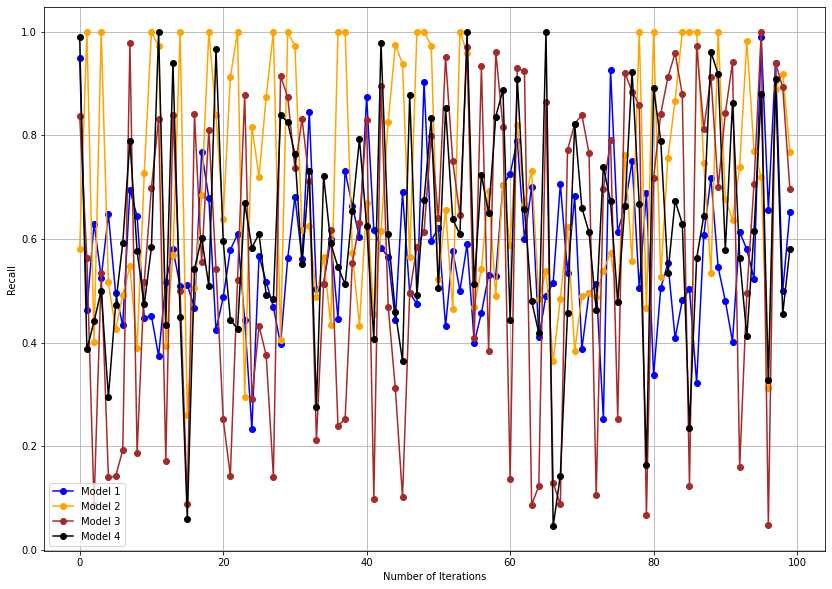

In [42]:
iterations = range(0, 100)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (14, 10))

plt.plot(iterations, md1_recall, marker = 'o', color = 'blue', label = 'Model 1')
plt.plot(iterations, md2_recall, marker = 'o', color = 'orange', label = 'Model 2')
plt.plot(iterations, md3_recall, marker = 'o', color = 'brown', label = 'Model 3')
plt.plot(iterations, md4_recall, marker = 'o', color = 'black', label = 'Model 4')

plt.xlabel('Number of Iterations')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()


In [43]:
np.mean(md1_recall)

0.5707804173203141

In [44]:
np.mean(md2_recall)

0.6958398990883161

In [45]:
np.mean(md3_recall)

0.5845049167454202

In [46]:
np.mean(md4_recall)

0.6169422580522904